In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKerasTF

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(1234)

import datasets
import losses
import cnns
import model

In [2]:
get_cnns = cnns.ResNet50
#get_cnns = cnns.SENet50
#get_cnns = cnns.VGG16

#dataset = datasets.SCUTFBP5500(get_cnns()[0])
dataset = datasets.MEBeauty(get_cnns()[0])

In [3]:
metrics = [
    tf.keras.metrics.KLDivergence(),
    losses.MeanAbsoluteError(dataset.n),
    losses.RootMeanSquaredError(dataset.n),
    losses.PearsonCorrelation(dataset.n),
    losses.MeanAbsoluteError(dataset.n, mode="var"),
    losses.RootMeanSquaredError(dataset.n, mode="var"),
    losses.PearsonCorrelation(dataset.n, mode="var"),
    losses.MeanAbsoluteError(dataset.n, mode="skew"),
    losses.RootMeanSquaredError(dataset.n, mode="skew"),
    losses.PearsonCorrelation(dataset.n, mode="skew")
]

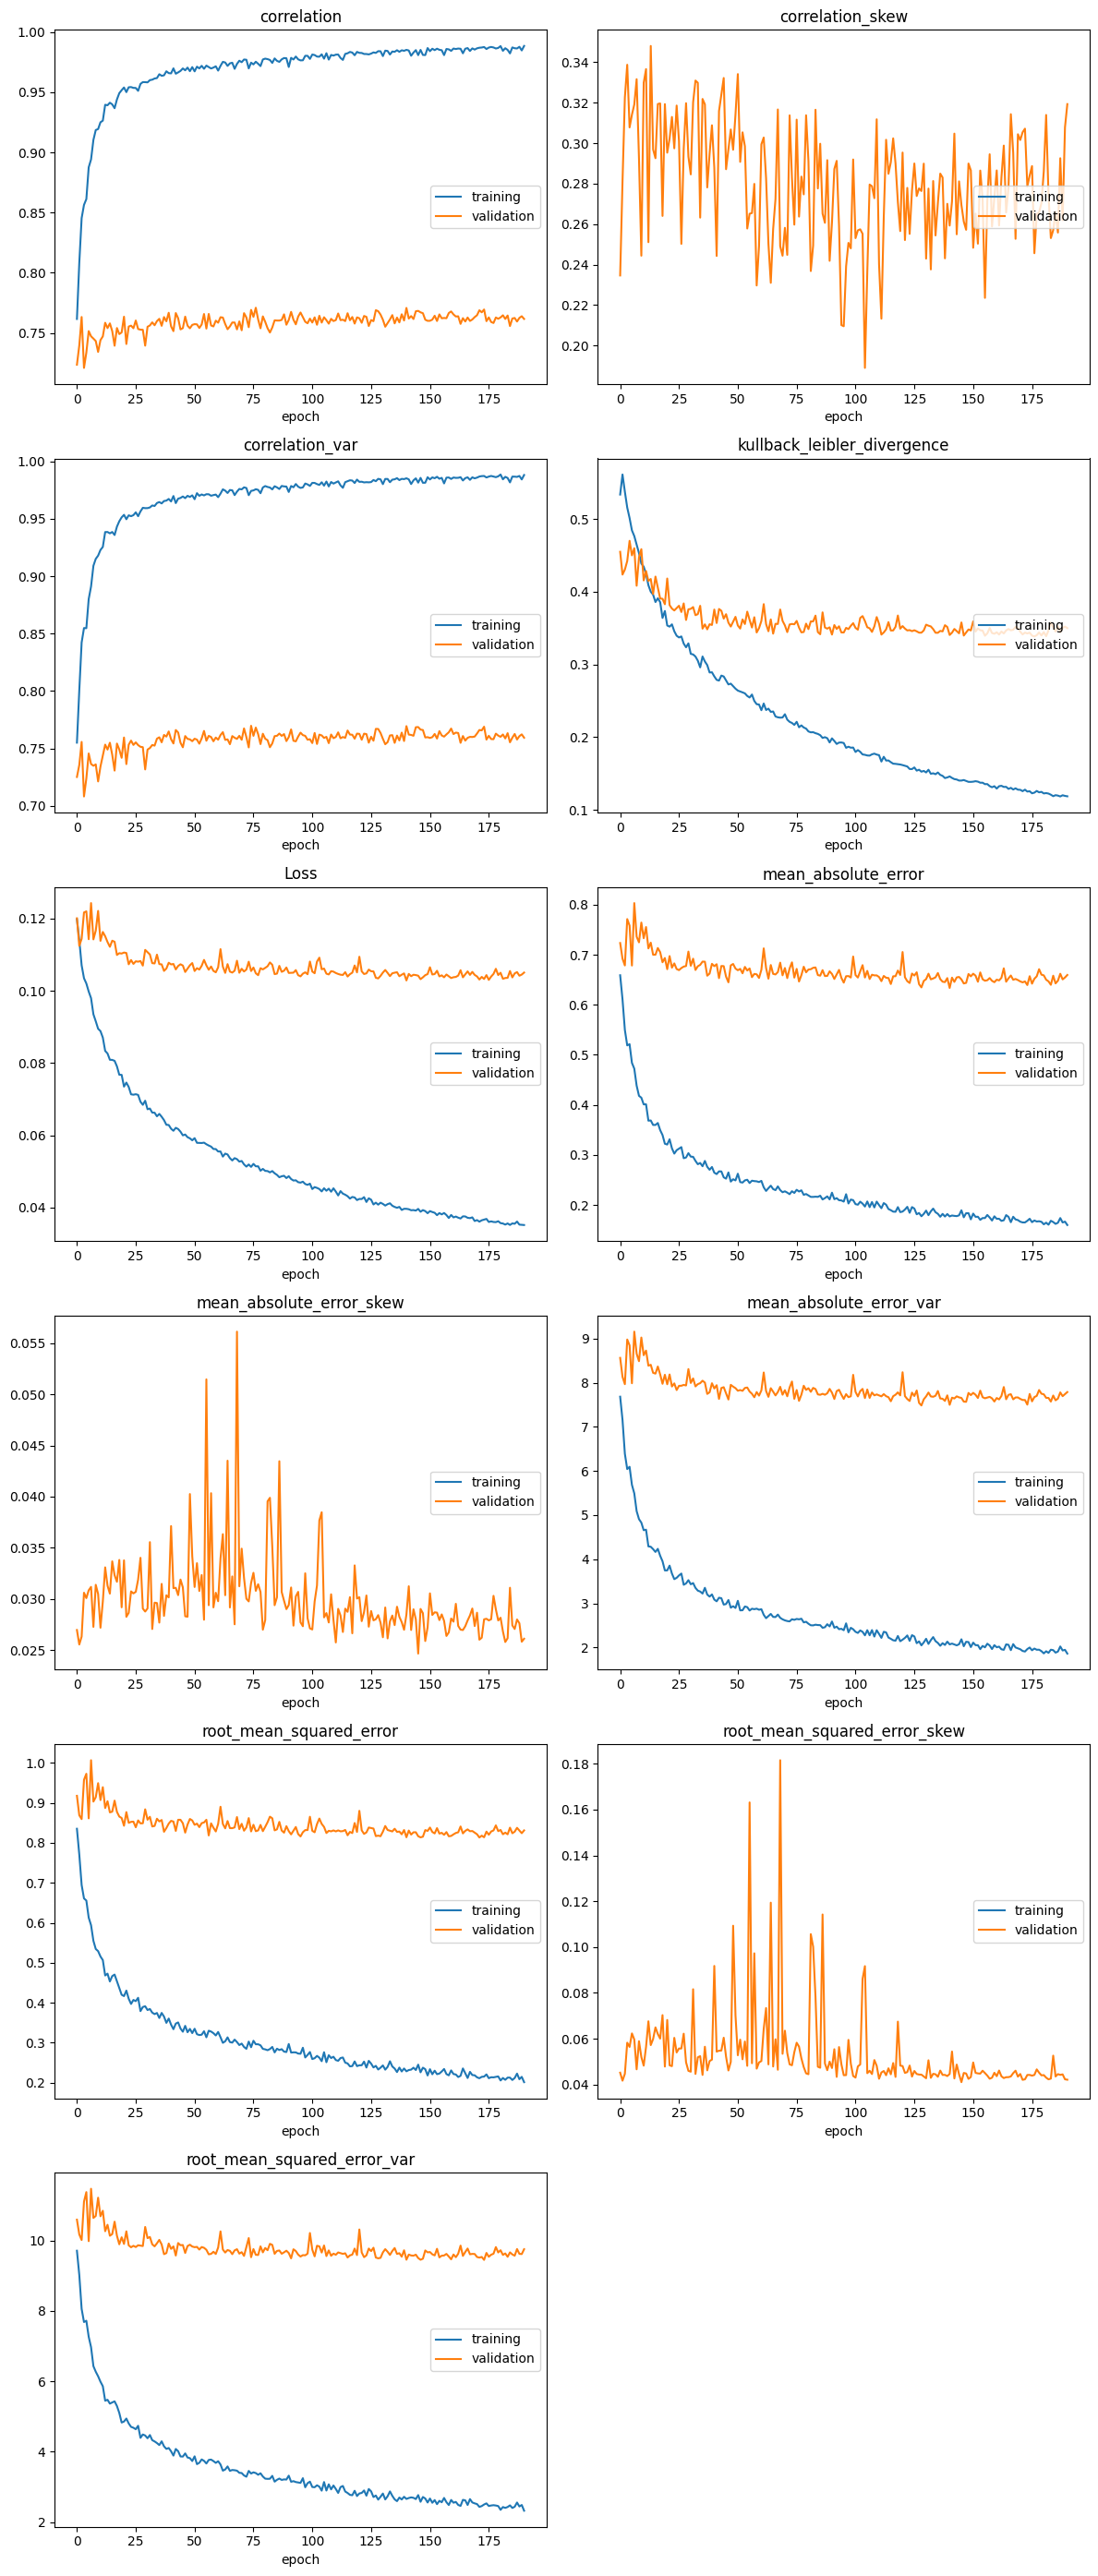

correlation
	training         	 (min:    0.762, max:    0.988, cur:    0.988)
	validation       	 (min:    0.721, max:    0.771, cur:    0.762)
correlation_skew
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:    0.189, max:    0.348, cur:    0.319)
correlation_var
	training         	 (min:    0.755, max:    0.989, cur:    0.988)
	validation       	 (min:    0.708, max:    0.770, cur:    0.759)
kullback_leibler_divergence
	training         	 (min:    0.118, max:    0.561, cur:    0.119)
	validation       	 (min:    0.338, max:    0.470, cur:    0.350)
Loss
	training         	 (min:    0.035, max:    0.120, cur:    0.035)
	validation       	 (min:    0.103, max:    0.124, cur:    0.105)
mean_absolute_error
	training         	 (min:    0.160, max:    0.659, cur:    0.160)
	validation       	 (min:    0.634, max:    0.803, cur:    0.660)
mean_absolute_error_skew
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	

In [4]:
y_pred_total = np.zeros(dataset.test.y.shape)
time_total = 0
k = 5 
model = model.Model(get_cnns, dataset)

for i in range(k):
    #dataset.shuffle()

    model.construct(supress=True)
    model.compile("emd", metrics=metrics)
    y_pred, time = model.train(iteration=i, monitor="val_mean_absolute_error")
    y_pred_total += y_pred
    time_total += time

y_pred_total /= k

In [5]:
#y_pred_total = np.zeros(dataset.test.y.shape)

#for i in range(k):  
    #y_pred_total += np.load(f"./SCUT-FBP5500/senet50/emd/y_pred_{i}.npy")
#y_pred_total /= k

In [6]:
print(time_total)
for m in metrics: print(np.round(m(dataset.test.y, y_pred_total), 4))

37.166166244999964
0.3412
0.6355
0.8227
[[0.7773]]
7.5135
9.5452
[[0.7745]]
0.0278
0.0537
[[0.2413]]
